## Classificador de imagens de dia e noite

Utilizando o conjunto de imagens do dataset do projeto [AMOS](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes), construir um classificador de imagens que dado uma determinada imagem deverá ser capaz em classificar em _dia_ ou _noite_.

Para este modelo, será levado em consideração como principal característica seu respectivo valor de brilho.

Exemplos de imagens disponíveis na pasta _imagens_.

_Dia_
![alt text](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-2-transformacao/desafio-3/imagens/test/day/20151101_152050.jpg?raw=1)

_Noite_
![alt text](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-2-transformacao/desafio-3/imagens/test/night/20151101_072507.jpg?raw=1)

## 1. Requerimentos

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV >= 3.4.3
* Matplotlib >= 3.1.3
* Seaborn >= 0.0.10
* Numpy >= 1.18.1

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [1]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 11787, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 11787 (delta 150), reused 338 (delta 134), pack-reused 11432
Receiving objects: 100% (11787/11787), 1.11 GiB | 22.91 MiB/s, done.
Resolving deltas: 100% (601/601), done.
Updating files: 100% (598/598), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório

In [2]:
%cd fiap-ml-visao-computacional/aula-2-transformacao/desafio-3/

/content/fiap-ml-visao-computacional/aula-2-transformacao/desafio-3


## 2. Principais atividades do _pipeline_

1. Normalizar
2. Extrair características
3. Construir classificador
4. Testar o modelo

*Adaptado deste [repositório](https://github.com/udacity/CVND_Exercises/blob/master/1_1_Image_Representation) de Visão Computacional da Udacity, de Cezanne Camacho.*

In [5]:
import os
import glob

import cv2

import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
def carregar_arquivos(image_dir):

    im_list = []
    image_types = ["day", "night"]

    for im_type in image_types:

        for file in glob.glob(os.path.join(image_dir, im_type, "*")):

            im = cv2.imread(file)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            if not im is None:
                im_list.append((im, im_type))

    return im_list

In [7]:
lista_imagens_teste = carregar_arquivos("imagens/test")
lista_imagens_treinamento = carregar_arquivos("imagens/training")

## 3. Normalização

Constuir uma função que receberá uma imagem e redimensionará para o tamanho 1000 x 600.

Esta a seguir possui 700 de altura 1300 de comprimento.

Text(0.5, 1.0, 'night')

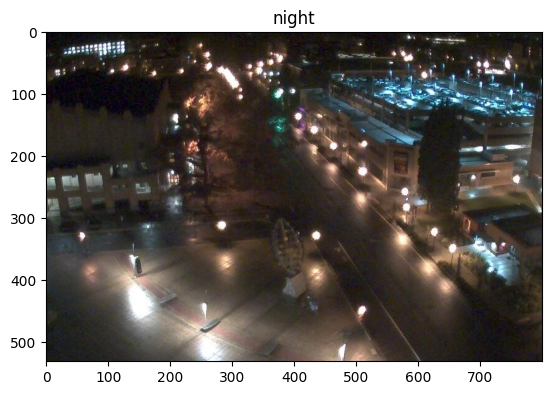

In [8]:
plt.imshow(lista_imagens_treinamento[200][0])
plt.title(lista_imagens_treinamento[200][1])


Já esta nova imagem é menor, possuindo 350 x 650 pixels.

Text(0.5, 1.0, 'day')

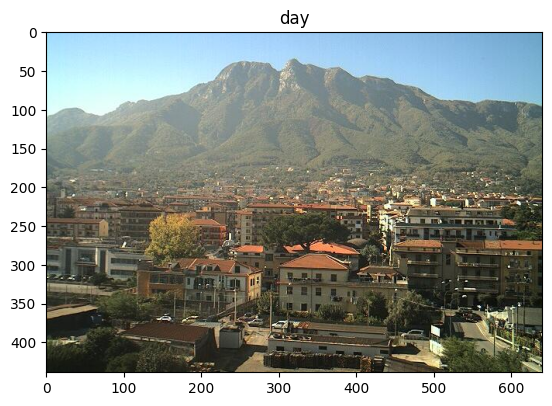

In [9]:
plt.imshow(lista_imagens_treinamento[0][0])
plt.title(lista_imagens_treinamento[0][1])

In [10]:
def padronizar_imagem(imagem):
    imagem_padrao = cv2.resize(imagem, (1000, 600), interpolation = cv2.INTER_LANCZOS4)

    return imagem_padrao

## 4. Extração de características

Para cada imagem analisada, extrair o componente de brilho médio associado.

In [11]:
def extrair_brilho_medio(imagem):
    hsv = cv2.cvtColor(imagem, cv2.COLOR_RGB2HSV)

    soma_brilho = np.sum(hsv[:,:,2])
    area = imagem.shape[0]*imagem.shape[1]

    media_brilho = soma_brilho/area

    return media_brilho

Agora vamos construir uma lista com todas as imagens e seus brilhos médios extraídos. Vamos também rotular as imagens utilizando hot-enconding, sendo 1 para dia e 0 para noite.

In [12]:
def extrair_caracteristica_imagem(lista_imagem):

    lista_imagem_padrao = []

    for imagem_dados in lista_imagem:
        imagem = imagem_dados[0]
        label = imagem_dados[1]

        imagem_redimensionada = padronizar_imagem(imagem)

        brilho_medio = extrair_brilho_medio(imagem_redimensionada)

        if label == "day":
            label_encoded = 1
        else:
            label_encoded = 0

        lista_imagem_padrao.append((brilho_medio, label_encoded))

    return lista_imagem_padrao

Testando a rotulação de imagem e padronização.

Text(0.5, 1.0, 'day')

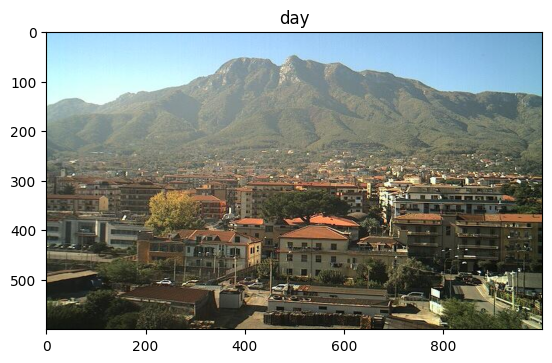

In [13]:
plt.imshow(padronizar_imagem(lista_imagens_treinamento[0][0]))
plt.title(lista_imagens_treinamento[0][1])

Text(0.5, 1.0, 'night')

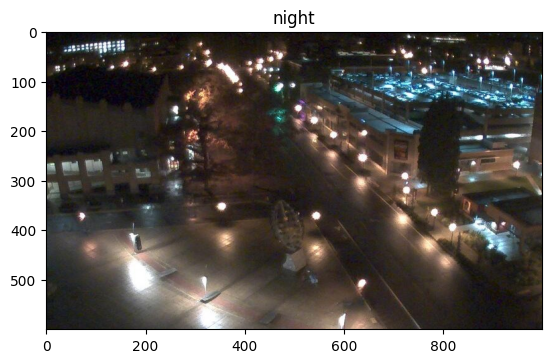

In [14]:
plt.imshow(padronizar_imagem(lista_imagens_treinamento[200][0]))
plt.title(lista_imagens_treinamento[200][1])

Obtendo as características de ambos os grupos de imagens, treinamento e testes.

In [15]:
lista_padronizada_treinamento = extrair_caracteristica_imagem(lista_imagens_treinamento)
lista_padronizada_teste = extrair_caracteristica_imagem(lista_imagens_teste)

## 5. Construção do classificador

Desenvolver um modelo de aprendizado de máquina que seja capaz de classificar adequadamente, com no mínimo 90% de acurácia, as imagens que representam o dia e a noite.

In [16]:
classificador_decision_tree = DecisionTreeClassifier(random_state=0)

A função a seguir é para padronizar a forma que o ``ScikitLearn`` obtém os dados, separando o que é classe (Y) do que é feature (X).

In [17]:
def definicao_feature_class(lista_padronizada):
    X = []
    Y = []

    for item in lista_padronizada:
        X.append(item[0])
        Y.append(item[1])

    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)

    return X, Y

In [18]:
X, Y = definicao_feature_class(lista_padronizada_treinamento)

In [19]:
classificador_decision_tree.fit(X, Y)

DecisionTreeClassifier(random_state=0)

Testando algumas classificações.

Text(0.5, 1.0, 'day')

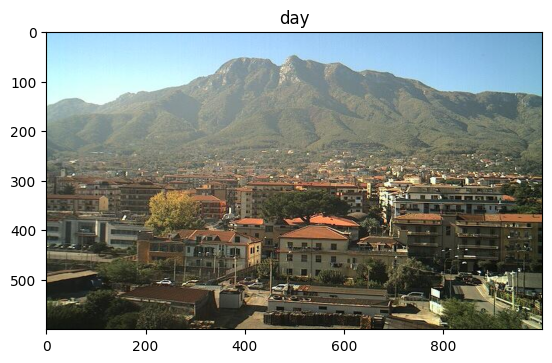

In [20]:
plt.imshow(padronizar_imagem(lista_imagens_treinamento[0][0]))
plt.title(lista_imagens_treinamento[0][1])

In [21]:
classificador_decision_tree.predict([[lista_padronizada_treinamento[0][0]]])

array([1])

Text(0.5, 1.0, 'night')

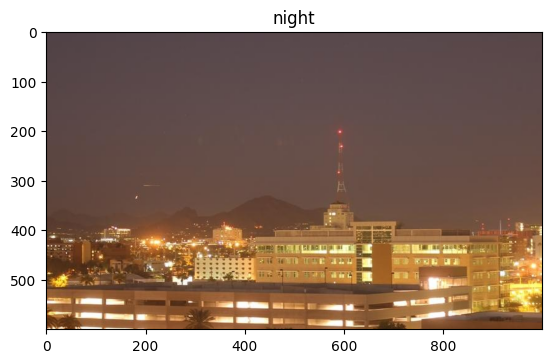

In [22]:
plt.imshow(padronizar_imagem(lista_imagens_treinamento[150][0]))
plt.title(lista_imagens_treinamento[150][1])

In [23]:
classificador_decision_tree.predict([[lista_padronizada_treinamento[150][0]]])

array([0])

## 6. Teste do modelo

Dado o conjunto de testes, verificar a acurácia do modelo.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X_test, Y_test = definicao_feature_class(lista_padronizada_teste)
Y_pred = classificador_decision_tree.predict(X_test)

## 6.1 Precisão

Calcular a precisão do modelo com base os dados de teste.

In [25]:
accuracy_score(Y_test,Y_pred)*100

91.25

## 6.2 Matriz de confusão

Calcular a matriz de confusão do modelo, levando em consideração os dados de teste.

In [26]:
confusion_matrix(Y_test, Y_pred)

array([[71,  9],
       [ 5, 75]])

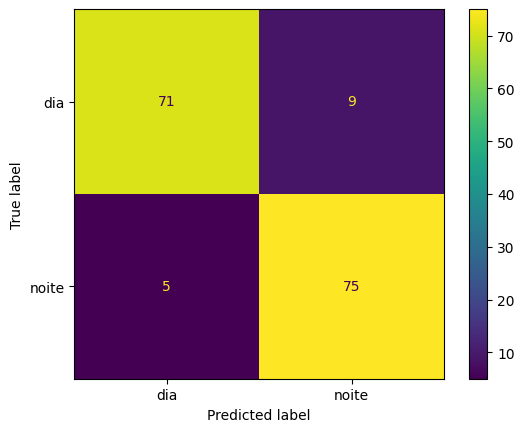

In [28]:
ConfusionMatrixDisplay.from_estimator(classificador_decision_tree, X_test, Y_test,
                                 display_labels=["dia", "noite"])